# balance Quickstart (CBPS): Analyzing and adjusting the bias on a simulated toy dataset

'balance' is a Python package that is maintained and released by the Core Data Science Tel-Aviv team in Meta. 'balance' performs and evaluates bias reduction by weighting for a broad set of experimental and observational use cases.

Although balance is written in Python, you don't need a deep Python understanding to use it. In fact, you can just use this notebook, load your data, change some variables and re-run the notebook and produce your own weights!

This quickstart demonstrates re-weighting specific simulated data, but if you have a different usecase or want more comprehensive documentation, you can check out the comprehensive balance tutorial.

## Analysis

There are four main steps to analysis with balance:
- load data
- check diagnostics before adjustment
- perform adjustment + check diagnostics
- output results

Let's dive right in!

## Example dataset

The following is a toy simulated dataset.

In [2]:
%matplotlib inline

import plotly.offline as offline
offline.init_notebook_mode()

from balance import load_data

INFO (2022-11-22 02:21:35,671) [__init__/<module> (line 52)]: Using balance version 0.1.1


In [3]:
target_df, sample_df = load_data()

print("target_df: \n", target_df.head())
print("sample_df: \n", sample_df.head())

target_df: 
        id gender age_group     income
0  100000   Male       45+  10.183951
1  100001   Male       45+   6.036858
2  100002   Male     35-44   5.226629
3  100003    NaN       45+   5.752147
4  100004    NaN     25-34   4.837484
sample_df: 
   id  gender age_group     income  happiness
0  0  Female     25-34   1.038463  55.975764
1  1    Male       45+   0.214603  58.645154
2  2    Male     35-44   2.322137  42.285653
3  3     NaN     18-24   0.086068  49.210985
4  4     NaN     35-44  17.156958  49.330845


In [4]:
target_df.head().round(2).to_dict()
# sample_df.shape

{'id': {0: '100000', 1: '100001', 2: '100002', 3: '100003', 4: '100004'},
 'gender': {0: 'Male', 1: 'Male', 2: 'Male', 3: nan, 4: nan},
 'age_group': {0: '45+', 1: '45+', 2: '35-44', 3: '45+', 4: '25-34'},
 'income': {0: 10.18, 1: 6.04, 2: 5.23, 3: 5.75, 4: 4.84}}

In practice, one can use pandas loading function(such as `read_csv()`) to import data into the DataFrame objects `sample_df` and `target_df`.

# Load data into a Sample object

The first thing to do is to import the `Sample` class from balance. All of the data we're going to be working with, sample or population, will be stored in objects of the `Sample` class.

In [5]:
from balance import Sample

Using the Sample class, we can fill it with a "sample" we want to adjust, and also a "target" we want to adjust towards.

We turn the two input pandas DataFrame objects we created (or loaded) into a balance.Sample objects, by using the `.from_frame()` 

In [6]:
sample = Sample.from_frame(sample_df, outcome_columns=["happiness"])
target = Sample.from_frame(target_df, outcome_columns=["happiness"])

WARNING (2022-11-22 02:21:55,352) [util/guess_id_column (line 111)]: Guessed id column name id for the data


WARNING (2022-11-22 02:21:55,381) [sample_class/from_frame (line 234)]: No weights passed, setting all weights to 1


WARNING (2022-11-22 02:21:55,418) [util/guess_id_column (line 111)]: Guessed id column name id for the data


WARNING (2022-11-22 02:21:55,447) [sample_class/from_frame (line 234)]: No weights passed, setting all weights to 1


If we use the `.df` property call, we can see the DataFrame stored in sample. We can see how we have a new weight column that was added (it will all have 1s) in the importing of the DataFrames into a `balance.Sample` object.

In [7]:
sample.df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         1000 non-null   object 
 1   gender     912 non-null    object 
 2   age_group  1000 non-null   object 
 3   income     1000 non-null   float64
 4   happiness  1000 non-null   float64
 5   weight     1000 non-null   int64  
dtypes: float64(2), int64(1), object(3)
memory usage: 47.0+ KB


We can get a quick overview text of each Sample object, but just calling it.

Let's take a look at what this produces:

In [8]:
sample

(balance.sample_class.Sample)

        balance Sample object
        1000 observations x 3 variables: gender,age_group,income
        id_column: id, weight_column: weight,
        outcome_columns: happiness
        

In [9]:
target

(balance.sample_class.Sample)

        balance Sample object
        10000 observations x 3 variables: gender,age_group,income
        id_column: id, weight_column: weight,
        outcome_columns: None
        

Next, we combine the sample object with the target object. This is what will allow us to adjust the sample to the target.

In [10]:
sample_with_target = sample.set_target(target)

Looking on `sample_with_target` now, it has the target atteched:

In [11]:
sample_with_target

(balance.sample_class.Sample)

        balance Sample object with target set
        1000 observations x 3 variables: gender,age_group,income
        id_column: id, weight_column: weight,
        outcome_columns: happiness
        
            target:
                 
	        balance Sample object
	        10000 observations x 3 variables: gender,age_group,income
	        id_column: id, weight_column: weight,
	        outcome_columns: None
	        
            3 common variables: age_group,gender,income
            

# Pre-Adjustment Diagnostics

We can use `.covars()` and then followup with `.mean()` and `.plot()` (barplots and qqplots) to get some basic diagnostics on what we got.

We can see how:
- The proportion of missing values in gender is similar in sample and target.
- We have younger people in the sample as compared to the target.
- We have more females than males in the sample, as compared to around 50-50 split for the (non NA) target.
- Income is more right skewed in the target as compared to the sample.

In [12]:
print(sample_with_target.covars().mean().T)

source                    self     target
_is_na_gender[T.True]  0.08800   0.089800
age_group[T.25-34]     0.30900   0.297400
age_group[T.35-44]     0.17200   0.299200
age_group[T.45+]       0.04600   0.206300
gender[Female]         0.26800   0.455100
gender[Male]           0.64400   0.455100
gender[_NA]            0.08800   0.089800
income                 5.99102  12.737608


In [13]:
print(sample_with_target.covars().asmd().T)

source                  self
age_group[T.25-34]  0.025375
age_group[T.35-44]  0.277771
age_group[T.45+]    0.396127
gender[Female]      0.375699
gender[Male]        0.379314
gender[_NA]         0.006296
income              0.517721
mean(asmd)          0.334860


In [14]:
print(sample_with_target.covars().asmd(aggregate_by_main_covar = True).T)

source          self
age_group   0.233091
gender      0.253769
income      0.517721
mean(asmd)  0.334860


In [15]:
sample_with_target.covars().plot()

# Adjusting Sample to Population (ipw and cbps)

Next, we adjust the sample to the target. The default method to be used is 'ipw' (which uses inverse probability/propensity weights, after running logistic regression with lasso regularization).

In [16]:
# Using ipw to fit survey weights
adjusted_ipw = sample_with_target.adjust()

INFO (2022-11-22 02:23:00,149) [ipw/ipw (line 408)]: Starting ipw function


INFO (2022-11-22 02:23:00,157) [adjustment/apply_transformations (line 236)]: Adding the variables: []


INFO (2022-11-22 02:23:00,158) [adjustment/apply_transformations (line 237)]: Transforming the variables: ['age_group', 'gender', 'income']


INFO (2022-11-22 02:23:00,220) [adjustment/apply_transformations (line 274)]: Final variables in output: ['age_group', 'gender', 'income']


INFO (2022-11-22 02:23:00,260) [ipw/ipw (line 442)]: Building model matrix


INFO (2022-11-22 02:23:00,438) [ipw/ipw (line 466)]: The formula used to build the model matrix: ['income + gender + age_group + _is_na_gender']


INFO (2022-11-22 02:23:00,439) [ipw/ipw (line 469)]: The number of columns in the model matrix: 16


INFO (2022-11-22 02:23:00,440) [ipw/ipw (line 470)]: The number of rows in the model matrix: 11000


INFO (2022-11-22 02:23:00,464) [ipw/ipw (line 501)]: Fitting logistic model


INFO (2022-11-22 02:23:03,089) [ipw/ipw (line 573)]: Chosen lambda for cv: [0.01386604]


INFO (2022-11-22 02:23:03,091) [ipw/ipw (line 581)]: Proportion null deviance explained [0.17374302]


In [17]:
adjusted_cbps = sample_with_target.adjust(method = "cbps")

INFO (2022-11-22 02:23:33,272) [cbps/cbps (line 409)]: Starting cbps function


INFO (2022-11-22 02:23:33,281) [adjustment/apply_transformations (line 236)]: Adding the variables: []


INFO (2022-11-22 02:23:33,282) [adjustment/apply_transformations (line 237)]: Transforming the variables: ['age_group', 'gender', 'income']


INFO (2022-11-22 02:23:33,336) [adjustment/apply_transformations (line 274)]: Final variables in output: ['age_group', 'gender', 'income']


INFO (2022-11-22 02:23:33,548) [cbps/cbps (line 460)]: The formula used to build the model matrix: ['income + gender + age_group + _is_na_gender']


INFO (2022-11-22 02:23:33,553) [cbps/cbps (line 472)]: The number of columns in the model matrix: 16


INFO (2022-11-22 02:23:33,554) [cbps/cbps (line 473)]: The number of rows in the model matrix: 11000


INFO (2022-11-22 02:23:33,659) [cbps/cbps (line 535)]: Finding initial estimator for GMM optimization


INFO (2022-11-22 02:23:33,984) [cbps/cbps (line 562)]: Finding initial estimator for GMM optimization that minimizes the balance loss


WARNING (2022-11-22 02:23:36,366) [cbps/cbps (line 579)]: Convergence of bal_loss function has failed due to 'Maximum number of function evaluations has been exceeded.'


INFO (2022-11-22 02:23:36,368) [cbps/cbps (line 597)]: Running GMM optimization


WARNING (2022-11-22 02:23:39,235) [cbps/cbps (line 612)]: Convergence of gmm_loss function with gmm_init start point has failed due to 'Maximum number of function evaluations has been exceeded.'


WARNING (2022-11-22 02:23:41,660) [cbps/cbps (line 630)]: Convergence of gmm_loss function with beta_balance start point has failed due to 'Maximum number of function evaluations has been exceeded.'


INFO (2022-11-22 02:23:41,681) [cbps/cbps (line 726)]: Done cbps function


In [18]:
print(adjusted_ipw)


        Adjusted balance Sample object with target set using ipw
        1000 observations x 3 variables: gender,age_group,income
        id_column: id, weight_column: weight,
        outcome_columns: happiness
        
            target:
                 
	        balance Sample object
	        10000 observations x 3 variables: gender,age_group,income
	        id_column: id, weight_column: weight,
	        outcome_columns: None
	        
            3 common variables: age_group,gender,income
            


In [19]:
# the adjusted object will look the same as ipw 
print(adjusted_cbps)


        Adjusted balance Sample object with target set using cbps
        1000 observations x 3 variables: gender,age_group,income
        id_column: id, weight_column: weight,
        outcome_columns: happiness
        
            target:
                 
	        balance Sample object
	        10000 observations x 3 variables: gender,age_group,income
	        id_column: id, weight_column: weight,
	        outcome_columns: None
	        
            3 common variables: age_group,gender,income
            


# Evaluation of the Results (CBPS vs IPW)

We can get a basic summary of the results:

In [20]:
print(adjusted_ipw.summary())

Covar ASMD reduction: 62.3%, design effect: 2.249
Covar ASMD (7 variables): 0.335 -> 0.126
Model performance: Model proportion deviance explained: 0.174


In [21]:
print(adjusted_cbps.summary())

Covar ASMD reduction: 83.7%, design effect: 3.646
Covar ASMD (7 variables): 0.335 -> 0.055



We can see that CBPS did a better job in terms of ASMD reduction. Let's look at it per feature:

We see an improvement in the average ASMD. We can look at detailed list of ASMD values per variables using the following call.

In [23]:
print("ipw:")
print(adjusted_ipw.covars().asmd().T)
print("\ncbps:")
print(adjusted_cbps.covars().asmd().T)

ipw:


source                  self  unadjusted  unadjusted - self
age_group[T.25-34]  0.040094    0.025375          -0.014719
age_group[T.35-44]  0.019792    0.277771           0.257980
age_group[T.45+]    0.137361    0.396127           0.258765
gender[Female]      0.089228    0.375699           0.286472
gender[Male]        0.061820    0.379314           0.317494
gender[_NA]         0.047739    0.006296          -0.041444
income              0.246918    0.517721           0.270802
mean(asmd)          0.126310    0.334860           0.208551

cbps:


source                  self  unadjusted  unadjusted - self
age_group[T.25-34]  0.000019    0.025375           0.025357
age_group[T.35-44]  0.044301    0.277771           0.233470
age_group[T.45+]    0.087002    0.396127           0.309125
gender[Female]      0.013026    0.375699           0.362673
gender[Male]        0.003963    0.379314           0.375350
gender[_NA]         0.029592    0.006296          -0.023296
income              0.104624    0.517721           0.413097
mean(asmd)          0.054642    0.334860           0.280219


It's easier to learn about the biases by just running `.covars().plot()` on our adjusted object.

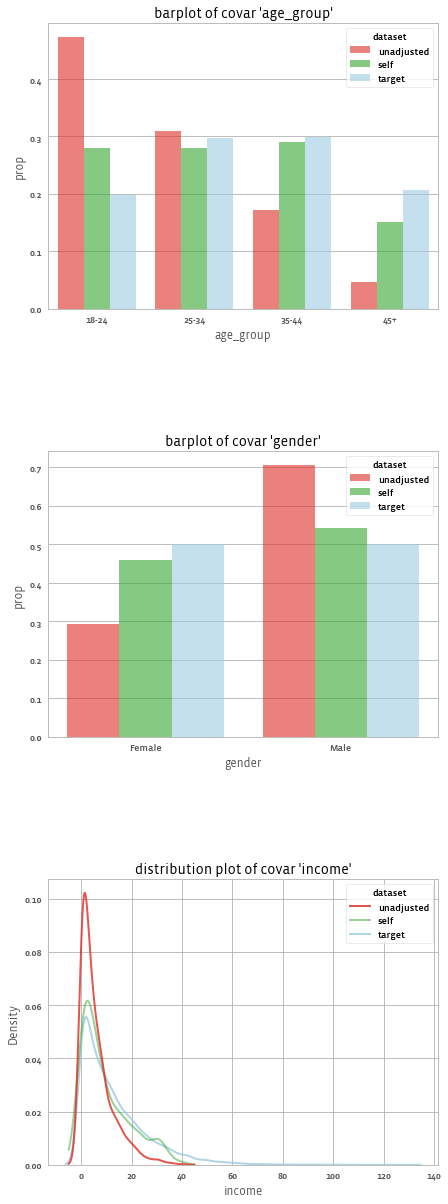

In [26]:
adjusted_ipw.covars().plot(library = "seaborn", dist_type = "kde")

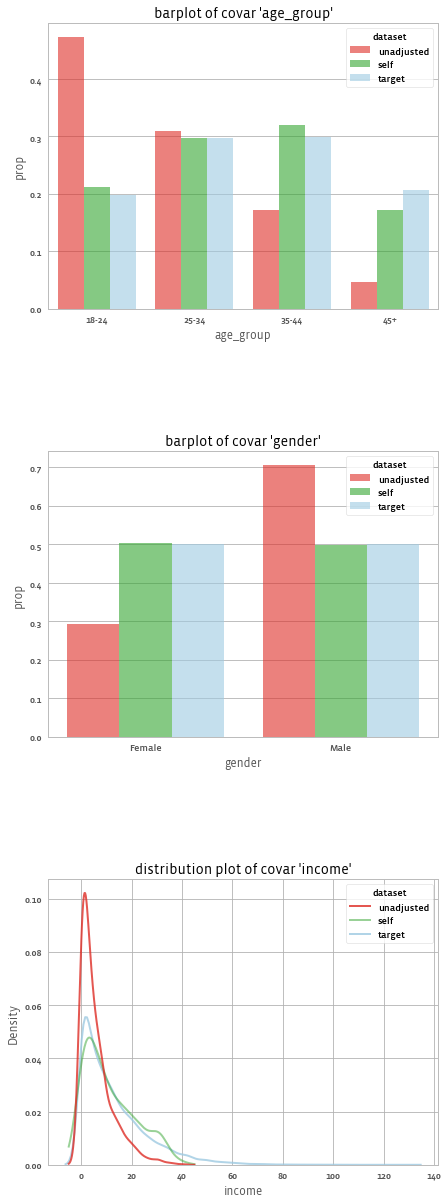

In [27]:
adjusted_cbps.covars().plot(library = "seaborn", dist_type = "kde")

We can also use different plots, using the seaborn library, for example with the "kde" dist_type.

### Understanding the weights

And get the design effect using:

In [28]:
print("ipw:")
print(adjusted_ipw.weights().design_effect())
print("\ncbps:")
print(adjusted_cbps.weights().design_effect())


ipw:
2.2493789945583806

cbps:
3.6458147446619216


# Outcome analysis

WARNING (2022-11-22 03:01:37,240) [balancedf_class/target_response_rates (line 1307)]: Sample does not have target set


1 outcomes: ['happiness']
Mean outcomes:
            happiness
source               
self        54.221388
unadjusted  48.392784

Response rates (relative to number of respondents in sample):
   happiness
n     1000.0
%      100.0





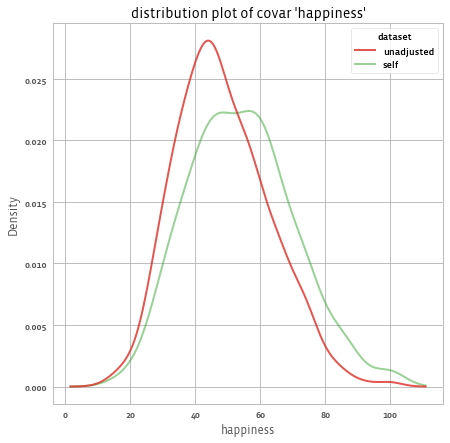

In [29]:
print(adjusted_ipw.outcomes().summary())
adjusted_ipw.outcomes().plot()

The estimated mean happiness according to our sample is 48 without any adjustment and 54 with adjustment.  The following show the distribution of happinnes:

WARNING (2022-11-22 03:01:46,849) [balancedf_class/target_response_rates (line 1307)]: Sample does not have target set


1 outcomes: ['happiness']
Mean outcomes:
            happiness
source               
self        55.821948
unadjusted  48.392784

Response rates (relative to number of respondents in sample):
   happiness
n     1000.0
%      100.0





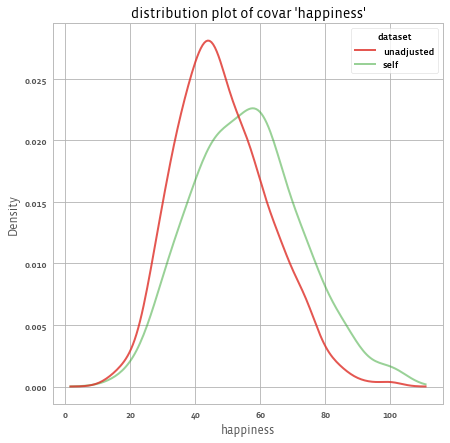

In [30]:
print(adjusted_cbps.outcomes().summary())
adjusted_cbps.outcomes().plot()

As we can see, CBPS has a larger design effect, but also fixes more of the ASMD and has an impact on the outcome. So there are pros and cons for each of the two methods.

# Downloading data

Finally, we can prepare the data to be downloaded for future analyses.

In [31]:
adjusted_cbps.to_download()

/tmp/tmp_balance_out_1f25078f-bf5e-4a43-b32f-adeddcc570a5.csv

In [32]:
# We can prepare the data to be exported as csv - showing the first 500 charaacters for simplicity:
adjusted_cbps.to_csv()[0:500]

'id,gender,age_group,income,happiness,weight\n0,Female,25-34,1.0384632065106263,55.9757637459091,12.161826248734409\n1,Male,45+,0.21460348629627557,58.645154141877306,2.7434938191419875\n2,Male,35-44,2.3221372597327745,42.28565260361035,7.3386456005085385\n3,,18-24,0.08606802599581903,49.21098472260077,2.537419452793263\n4,,35-44,17.156958197550072,49.33084508361814,33.11812092746495\n5,,35-44,4.257130738748466,67.46904416515795,13.01780976853926\n6,,25-34,1.0092927734150772,40.03387164850365,6.83468834'

In [ ]:
# Sessions info
import session_info
session_info.show(html=False, dependencies=True)